## Creacion de modelo Predictivo.

In [17]:
%load_ext autoreload
%autoreload 2

import pickle

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import warnings

import sys
sys.path.append('../..')

from src import soporte_regresion as sup_regre

##aplicar configuraciones
#------------------------------------------------------------------------
warnings.filterwarnings('ignore')
pd.set_option('display.max_info_columns', 50)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) #eliminamos la notacion cientifica

tqdm.pandas()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
---

## Importamos los datos ya tratados en el notebook ```3_Encoding.ipynb```.

In [18]:
df = pd.read_csv('../../datos/datos_modelo1/tratados/encoded_propiedades_provincia_madrid.csv', index_col=0).reset_index(drop=True)
df.sample()

,numPhotos,price,size,exterior,rooms,bathrooms,municipality,showAddress,distance,hasVideo,newDevelopment,hasPlan,has3DTour,has360,topNewDevelopment,district,neighborhood,hasLift,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_Desconocido,floor_bj,floor_en,floor_ss,floor_st
186,-1.08,450.00,0.12,True,-1.00,0.00,665.56,False,1.96,False,False,False,False,False,False,645.66,679.79,False,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


## Creamos el modelo para predecir el precio.

In [19]:
X = df.drop(columns=['price'])
y = df[['price']]

X_train, X_test, y_train,y_test = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

In [20]:
# Parámetros a evaluar
params_arbol_prueba2 = {
    'max_depth': [2,3,4,5],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_leaf_nodes': [5, 10, 12, 15]
}

grid_search_arbol_2=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba2 , cv=10, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [5, 10, 12, 15],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [21]:
modelo_final_arbol_2=grid_search_arbol_2.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_2

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_leaf=2,
                      min_samples_split=15)

In [22]:
y_pred_test_arb_2= modelo_final_arbol_2.predict(X_test)
y_pred_train_arb_2= modelo_final_arbol_2.predict(X_train)
df_metricas_arbol_2= sup_regre.metricas(y_train, y_pred_train_arb_2, y_test, y_pred_test_arb_2)

df_metricas_arbol_2=df_metricas_arbol_2.T.reset_index()
df_metricas_arbol_2

,index,r2_score,MAE,MSE,RMSE
0,train,0.62,29.66,1516.34,38.94
1,test,0.40,32.60,1768.06,42.05


---
---

## Vemos la importancia de las variables


In [23]:
df_importancia_variables = pd.DataFrame(modelo_final_arbol_2.feature_importances_, columns= ["Importancia"], index= X.columns).sort_values(by = "Importancia", ascending=False)

In [24]:
df_importancia_variables_menor_0 = df_importancia_variables[df_importancia_variables['Importancia'] < 0.01]

In [25]:
df_importancia_variables_menor_0[:3]

,Importancia
numPhotos,0.00
floor_3,0.00
status_newdevelopment,0.00


## Reedefinimos nuestra X e y quitando todas las varibales que no tengan importancia

In [26]:
X = df.drop(columns=(['price', 'propertyType_studio', 'numPhotos', 'propertyType_studio'] + list(df_importancia_variables_menor_0.index)))
y = df[['price']]

X_train, X_test, y_train,y_test = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

In [27]:
# Parámetros a evaluar
params_arbol_prueba2 = {
    'max_depth': [2,3,4,5],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1,2,3,4],
    'max_leaf_nodes': [ 8, 9, 10, 11]
}

grid_search_arbol_2=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba2 , cv=10, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [8, 9, 10, 11],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [28]:
modelo_final_arbol_2=grid_search_arbol_2.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_2

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=11, min_samples_leaf=4,
                      min_samples_split=15)

In [29]:
y_pred_test_arb_2= modelo_final_arbol_2.predict(X_test)
y_pred_train_arb_2= modelo_final_arbol_2.predict(X_train)
df_metricas_arbol_2= sup_regre.metricas(y_train, y_pred_train_arb_2, y_test, y_pred_test_arb_2)

df_metricas_arbol_2=df_metricas_arbol_2.T.reset_index()
df_metricas_arbol_2

,index,r2_score,MAE,MSE,RMSE
0,train,0.61,29.15,1521.81,39.01
1,test,0.42,31.55,1708.27,41.33


## (guardamos nuestro modelo para reutilizarlo posteriormente en nuestra pagina web interactiva)

In [30]:
with open('../../src/modelos/model_decision_tree_regressor.pkl', 'wb') as f:
    pickle.dump(modelo_final_arbol_2, f)

## Variables que utilizamos finalmente

In [31]:
pd.DataFrame(modelo_final_arbol_2.feature_importances_, columns= ["Importancia"], index= X.columns).sort_values(by = "Importancia", ascending=False)

,Importancia
municipality,0.68
district,0.14
size,0.13
neighborhood,0.04


---
---

## Visualizamos los resultados

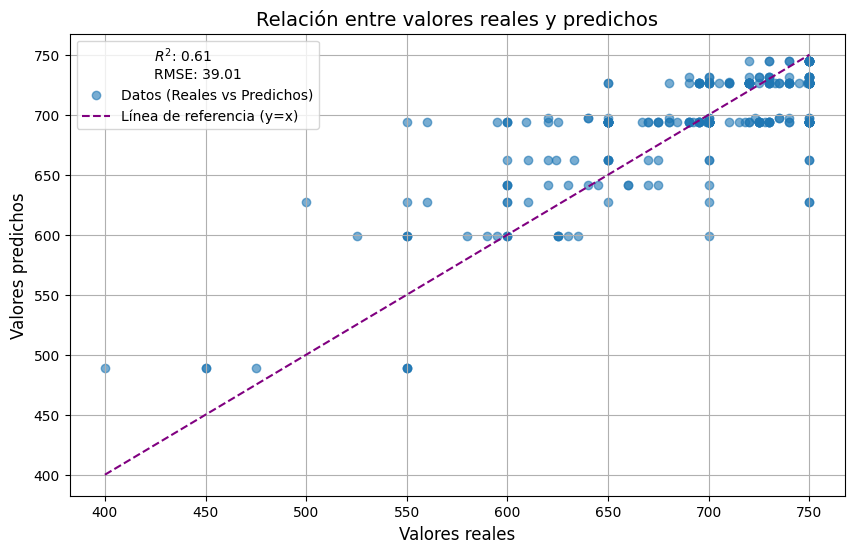

In [32]:
r2 = r2_score(y_train['price'], y_pred_train_arb_2)
rmse = np.sqrt(mean_squared_error(y_train['price'], y_pred_train_arb_2))

# Crear figura
plt.figure(figsize=(10, 6))

# Scatterplot con las variables reales y predichas
plt.scatter(y_train['price'], y_pred_train_arb_2, alpha=0.6, label='Datos (Reales vs Predichos)')

# Línea de referencia (y = x)
max_val = max(max(y_train['price']), max(y_pred_train_arb_2))
min_val = min(min(y_train['price']), min(y_pred_train_arb_2))
plt.plot([min_val, max_val], [min_val, max_val], color='purple', linestyle='--', label='Línea de referencia (y=x)')

# Etiquetas y título
plt.title('Relación entre valores reales y predichos', fontsize=14)
plt.xlabel('Valores reales', fontsize=12)
plt.ylabel('Valores predichos', fontsize=12)

# Leyenda con R2 y RMSE
plt.legend(title=f"$R^2$: {r2:.2f}\nRMSE: {rmse:.2f}")

# Mostrar gráfico
plt.grid(True)
plt.show()

---
---

<h3 style="color: #9966CC"><b>
Probar a eliminar variables que no sean importantes para el modelo
</b></h3>